### Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os 
os.chdir("/content/drive/MyDrive/predict_thermal_conductivity")

In [ ]:
#import required libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf  
from tensorflow import keras 
from tensorflow.keras.layers.experimental import preprocessing

# ANN model for in-plane thermal conductivity prediction

In [ ]:
# Read the dataset  
k11_df = pd.read_excel('/content/drive/MyDrive/predict_thermal_conductivity/Results_updated_k11.xlsx')
k11_df.head()

,Vf,Discrete_input,Ty/Sy,Wy/Sy,K11
0,0.25,"Plain(1,0,0)",0.1,0.8,0.928251
1,0.35,"Plain(1,0,0)",0.1,0.8,1.235390
2,0.45,"Plain(1,0,0)",0.1,0.8,1.542542
3,0.55,"Plain(1,0,0)",0.1,0.8,1.853576
4,0.65,"Plain(1,0,0)",0.1,0.8,2.164610


**Clean the data**

In [ ]:
k11_df.isnull().sum()

Vf                0
Discrete_input    0
Ty/Sy             0
Wy/Sy             0
K11               0
dtype: int64

No null values are present.

The **Discrete input** is categorical not numeric. So we need to convert it to a **one hot encoding** with **pd.dummies**:

In [ ]:
k11_df = pd.get_dummies(k11_df, columns=['Discrete_input'])

In [ ]:
k11_df.head()

,Vf,Ty/Sy,Wy/Sy,K11,"Discrete_input_5HS(0,0,1)","Discrete_input_Plain(1,0,0)","Discrete_input_Twill(0,1,0)"
0,0.25,0.1,0.8,0.928251,0,1,0
1,0.35,0.1,0.8,1.235390,0,1,0
2,0.45,0.1,0.8,1.542542,0,1,0
3,0.55,0.1,0.8,1.853576,0,1,0
4,0.65,0.1,0.8,2.164610,0,1,0


**Data visualization**

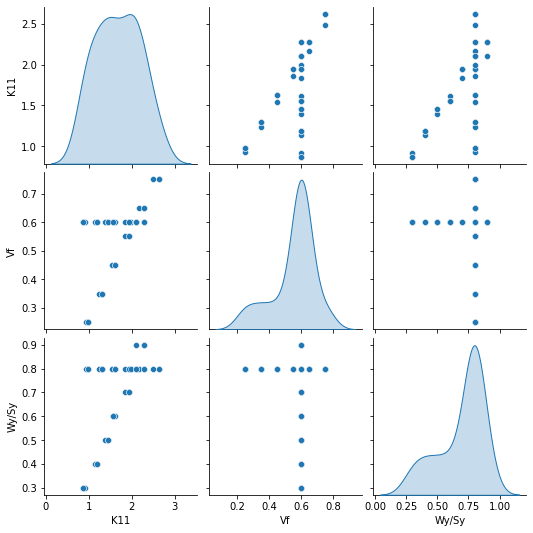

In [ ]:
sns.pairplot(k11_df[['K11', 'Vf', 'Wy/Sy']], diag_kind='kde')

**Split features from labels**

In [ ]:
feats = k11_df.drop('K11', axis=1)
labels = k11_df['K11']

print("Features shape:", feats.shape)
print("Labels shape:", labels.shape)

Features shape: (39, 6)
Labels shape: (39,)


**Build an ANN model**

In [ ]:
in_plane_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
# Compile the model
in_plane_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss = 'mean_absolute_error')

In [ ]:
# Train the model 
%%time 
history = in_plane_model.fit(
    feats, labels, 
    epochs = 175,
    validation_split=0.2  # 20% of features data
)

Epoch 1/175
1/1 [==============================] - 1s 759ms/step - loss: 1.5491 - val_loss: 1.4662
Epoch 2/175
1/1 [==============================] - 0s 29ms/step - loss: 1.5096 - val_loss: 1.4234
Epoch 3/175
1/1 [==============================] - 0s 31ms/step - loss: 1.4704 - val_loss: 1.3807
Epoch 4/175
1/1 [==============================] - 0s 26ms/step - loss: 1.4309 - val_loss: 1.3380
Epoch 5/175
1/1 [==============================] - 0s 22ms/step - loss: 1.3913 - val_loss: 1.2949
Epoch 6/175
1/1 [==============================] - 0s 23ms/step - loss: 1.3520 - val_loss: 1.2516
Epoch 7/175
1/1 [==============================] - 0s 23ms/step - loss: 1.3140 - val_loss: 1.2079
Epoch 8/175
1/1 [==============================] - 0s 21ms/step - loss: 1.2764 - val_loss: 1.1632
Epoch 9/175
1/1 [==============================] - 0s 21ms/step - loss: 1.2390 - val_loss: 1.1172
Epoch 10/175
1/1 [==============================] - 0s 26ms/step - loss: 1.2004 - val_loss: 1.0703
Epoch 11/175
1/1 [

**Visualize the model's training progress using the stats stored in the history object.**

In [ ]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.head()

,loss,val_loss,epoch
0,1.549112,1.466234,0
1,1.509612,1.423374,1
2,1.470374,1.380719,2
3,1.430913,1.338048,3
4,1.391272,1.294924,4


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('MSE [K11]')
  plt.legend()
  plt.grid(True)

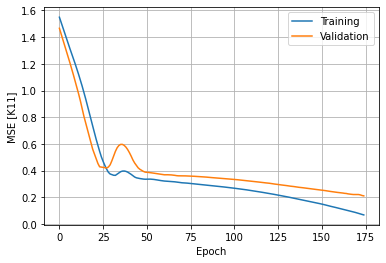

In [ ]:
# Plot loss
plot_loss(history)

### Model predictions

In [ ]:
y_pred = in_plane_model.predict(feats)
y_true = labels     
k11_results = pd.DataFrame(y_pred, columns=['y_pred'])
k11_results['y_true'] = y_true
k11_results.head()

,y_pred,y_true
0,1.175673,0.928251
1,1.405660,1.235390
2,1.639115,1.542542
3,1.872570,1.853576
4,2.106025,2.164610


In [ ]:
k11_df['K11_predicted'] = y_pred

In [ ]:
k11_df.head()

,Vf,Ty/Sy,Wy/Sy,K11,"Discrete_input_5HS(0,0,1)","Discrete_input_Plain(1,0,0)","Discrete_input_Twill(0,1,0)",K11_predicted
0,0.25,0.1,0.8,0.928251,0,1,0,1.175673
1,0.35,0.1,0.8,1.235390,0,1,0,1.405660
2,0.45,0.1,0.8,1.542542,0,1,0,1.639115
3,0.55,0.1,0.8,1.853576,0,1,0,1.872570
4,0.65,0.1,0.8,2.164610,0,1,0,2.106025


In [ ]:
k11_df.to_csv("K11_results.csv", index=False)

best fit line:
y = [0.364] + [0.807]x


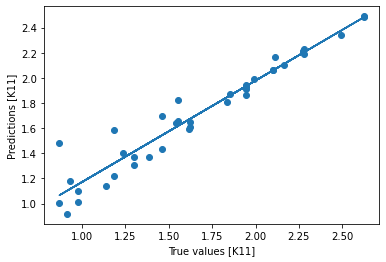

In [ ]:
#Plot predictions
def best_fit(y_true, y_pred):

    y_true_bar = sum(y_true)/len(y_true)
    y_pred_bar = sum(y_pred)/len(y_pred)
    n = len(y_true) # or len(y_pred)

    numer = sum([xi*yi for xi,yi in zip(y_true, y_pred)]) - n * y_true_bar * y_pred_bar
    denum = sum([xi**2 for xi in y_true]) - n * y_true_bar**2

    b = numer / denum
    a = y_pred_bar - b * y_true_bar

    print('best fit line:\ny = {} + {}x'.format(a, b))

    return a, b

# solution
a, b = best_fit(y_true.values, y_pred)
#best fit line:
#y = 0.80 + 0.92x

# plot points and fit line
import matplotlib.pyplot as plt
plt.scatter(y_true.values, y_pred)
yfit = [a + b * xi for xi in y_true.values]
plt.xlabel('True values [K11]')
plt.ylabel('Predictions [K11]')
plt.plot(y_true.values, yfit)

# ANN model for out of plane thermal conductivity prediction

In [ ]:
# Read the dataset  
k33_df = pd.read_excel('/content/drive/MyDrive/predict_thermal_conductivity/Results_updated_k33.xlsx')
k33_df.head()

,Vf,Discrete_input,Ty/Sy,Wy/Sy,K33,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Fig12(b)ref
0,0.25,"Plain(1,0,0)",0.1,0.8,0.237818,NaN,NaN,NaN,NaN,NaN
1,0.35,"Plain(1,0,0)",0.1,0.8,0.262592,NaN,NaN,NaN,NaN,NaN
2,0.45,"Plain(1,0,0)",0.1,0.8,0.289824,NaN,NaN,NaN,NaN,NaN
3,0.55,"Plain(1,0,0)",0.1,0.8,0.321724,NaN,NaN,NaN,NaN,NaN
4,0.65,"Plain(1,0,0)",0.1,0.8,0.354853,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Skip redunctant columns
k33_df = k33_df.iloc[:, :5]
k33_df.head()

,Vf,Discrete_input,Ty/Sy,Wy/Sy,K33
0,0.25,"Plain(1,0,0)",0.1,0.8,0.237818
1,0.35,"Plain(1,0,0)",0.1,0.8,0.262592
2,0.45,"Plain(1,0,0)",0.1,0.8,0.289824
3,0.55,"Plain(1,0,0)",0.1,0.8,0.321724
4,0.65,"Plain(1,0,0)",0.1,0.8,0.354853


**Clean the data**

In [ ]:
k33_df.isnull().sum()

Vf                0
Discrete_input    0
Ty/Sy             0
Wy/Sy             0
K33               0
dtype: int64

No null values are present.

The **Discrete input** is categorical not numeric. So we need to convert it to a **one hot encoding** with **pd.dummies**:

In [ ]:
k33_df = pd.get_dummies(k33_df, columns=['Discrete_input'])

In [ ]:
k33_df.head()

,Vf,Ty/Sy,Wy/Sy,K33,"Discrete_input_5HS(0,0,1)","Discrete_input_Plain(1,0,0)","Discrete_input_Twill(0,1,0)"
0,0.25,0.1,0.8,0.237818,0,1,0
1,0.35,0.1,0.8,0.262592,0,1,0
2,0.45,0.1,0.8,0.289824,0,1,0
3,0.55,0.1,0.8,0.321724,0,1,0
4,0.65,0.1,0.8,0.354853,0,1,0


**Data visualization**

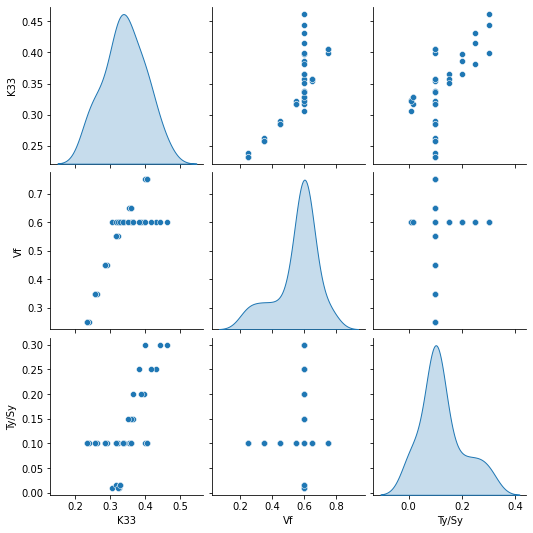

In [ ]:
sns.pairplot(k33_df[['K33', 'Vf', 'Ty/Sy']], diag_kind='kde')

**Split features from labels**

In [ ]:
feats_ = k33_df.drop('K33', axis=1)
labels_ = k33_df['K33']

print("Features shape:", feats_.shape)
print("Labels shape:", labels_.shape)

Features shape: (39, 6)
Labels shape: (39,)


**Build an ANN model**

In [ ]:
out_plane_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(1)
])

In [ ]:
# Compile the model
out_plane_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss = 'mean_absolute_error')

In [ ]:
# Train the model 
%%time 
history_ = out_plane_model.fit(
    feats_, labels_, 
    epochs = 175,
    validation_split=0.2  # 20% of features data
)

Epoch 1/175
1/1 [==============================] - 0s 484ms/step - loss: 0.3887 - val_loss: 0.4575
Epoch 2/175
1/1 [==============================] - 0s 25ms/step - loss: 0.3490 - val_loss: 0.4314
Epoch 3/175
1/1 [==============================] - 0s 20ms/step - loss: 0.3090 - val_loss: 0.4039
Epoch 4/175
1/1 [==============================] - 0s 23ms/step - loss: 0.2692 - val_loss: 0.3740
Epoch 5/175
1/1 [==============================] - 0s 22ms/step - loss: 0.2306 - val_loss: 0.3416
Epoch 6/175
1/1 [==============================] - 0s 22ms/step - loss: 0.1927 - val_loss: 0.3071
Epoch 7/175
1/1 [==============================] - 0s 22ms/step - loss: 0.1550 - val_loss: 0.2702
Epoch 8/175
1/1 [==============================] - 0s 23ms/step - loss: 0.1176 - val_loss: 0.2316
Epoch 9/175
1/1 [==============================] - 0s 25ms/step - loss: 0.0874 - val_loss: 0.1930
Epoch 10/175
1/1 [==============================] - 0s 26ms/step - loss: 0.0742 - val_loss: 0.1548
Epoch 11/175
1/1 [

**Visualize the model's training progress using the stats stored in the history object.**

In [ ]:
history_df1 = pd.DataFrame(history_.history)
history_df1['epoch'] = history_.epoch
history_df1.head()

,loss,val_loss,epoch
0,0.388732,0.457460,0
1,0.348957,0.431397,1
2,0.308989,0.403873,2
3,0.269171,0.373989,3
4,0.230582,0.341609,4


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('MSE [K33]')
  plt.legend()
  plt.grid(True)

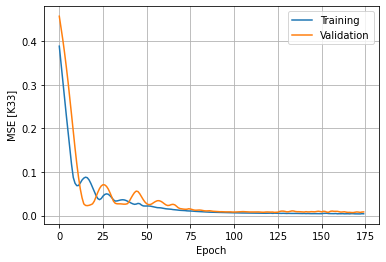

In [ ]:
# Plot loss
plot_loss(history_)

### Model predictions

In [ ]:
y_pred_ = out_plane_model.predict(feats_)
y_true_ = labels_     
k33_results = pd.DataFrame(y_pred_, columns=['y_pred'])
k33_results['y_true'] = y_true_
k33_results.head()

,y_pred,y_true
0,0.233946,0.237818
1,0.262140,0.262592
2,0.290765,0.289824
3,0.321292,0.321724
4,0.356487,0.354853


In [ ]:
k33_df['K33_predicted'] = y_pred_

In [ ]:
k33_df.head()

,Vf,Ty/Sy,Wy/Sy,K33,"Discrete_input_5HS(0,0,1)","Discrete_input_Plain(1,0,0)","Discrete_input_Twill(0,1,0)",K33_predicted
0,0.25,0.1,0.8,0.237818,0,1,0,0.233946
1,0.35,0.1,0.8,0.262592,0,1,0,0.262140
2,0.45,0.1,0.8,0.289824,0,1,0,0.290765
3,0.55,0.1,0.8,0.321724,0,1,0,0.321292
4,0.65,0.1,0.8,0.354853,0,1,0,0.356487


In [ ]:
k33_df.to_csv("K33_results.csv", index=False)

best fit line:
y = [0.003] + [0.988]x


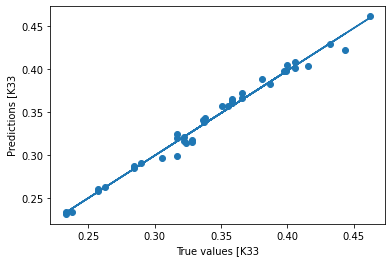

In [ ]:
# solution
a1, b1 = best_fit(y_true_.values, y_pred_)
#best fit line:
#y = 0.80 + 0.92x

# plot points and fit line
import matplotlib.pyplot as plt
plt.scatter(y_true_.values, y_pred_)
yfit = [a1 + b1 * xi for xi in y_true_.values]
plt.xlabel('True values [K33')
plt.ylabel('Predictions [K33')
plt.plot(y_true_.values, yfit)